In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import sys
module_path = os.path.abspath("/workspace/categorical-dsm/")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from torchinfo import summary
from models.score_base import TabScoreModel

import seaborn as sns
import matplotlib as mpl

mpl.rc('figure', figsize=(10, 4), dpi=100)
sns.set_theme()

In [3]:
from configs import chess_config as cfg

config = cfg.get_config()
config

data:
  anomaly_label: '1'
  categories:
  - 4
  - 4
  - 8
  - 8
  - 8
  - 8
  dataset: chess
  label_column: class
  numerical_features: 0
device: !!python/object/apply:torch.device
- cpu
devtest: false
eval:
  batch_size: 1024
model:
  act: gelu
  dropout: 0.0
  ema_rate: 0.999
  embedding_type: fourier
  estimate_noise: true
  layers: 20
  name: tab-resnet
  ndims: 1024
  num_scales: 20
  sigma_max: 1.0
  sigma_min: 0.1
  tau_max: 20
  tau_min: 2.0
  time_embedding_size: 128
msma:
  checkpoint: best
  denoise: true
optim:
  beta1: 0.9
  beta2: 0.999
  grad_clip: 1.0
  lr: 0.001
  optimizer: AdamW
  scheduler: cosine
  weight_decay: 0.0001
seed: 42
sweep:
  early_terminate:
    eta: 2
    min_iter: 50000
    s: 3
    type: hyperband
  method: bayes
  metric:
    name: val_loss
  parameters:
    model_act:
      values:
      - gelu
      - swish
    model_dropout:
      values:
      - 0.0
      - 0.1
      - 0.2
      - 0.3
      - 0.4
      - 0.5
    model_embedding_type:
      val

In [4]:
sum(config.data.categories)

40

In [5]:
assert config.data.dataset == "chess"

In [6]:
workdir = f"/workspace/categorical-dsm/results/{config.data.dataset}/"
workdir

'/workspace/categorical-dsm/results/chess/'

In [7]:
from ood_detection_helper import ood_metrics, auxiliary_model_analysis


def get_msma_results(workdir, ckpt_num=-1, seed=0):
    #TODO: USE PYOD MODELS!
    np.random.seed(42)
    workdir = os.path.join(workdir, f"seed_{seed}")
    denoise = config.msma.denoise
    ckpt_dir = os.path.join(workdir, "checkpoints")
    ckpts = sorted(os.listdir(ckpt_dir))
    ckpt = ckpts[ckpt_num]
    step = ckpt.split("-")[0]
    fname = os.path.join(
            workdir, "score_norms", f"{step}-{'denoise' if denoise else ''}-score_norms.npz"
        )
    with np.load(fname, allow_pickle=True) as npzfile:
        outdict = {k: npzfile[k].item() for k in npzfile.files}


    X_train = outdict["train"]["score_norms"]
    np.random.shuffle(X_train)
    X_val = outdict["val"]["score_norms"]
    X_train = np.concatenate((X_train, X_val))
    test_labels = outdict["test"]["labels"]
    X_test = outdict["test"]["score_norms"][test_labels == 0]
    X_ano = outdict["test"]["score_norms"][test_labels == 1]
    results = auxiliary_model_analysis(X_train, X_test, [X_ano],
                                    components_range=range(3,11,2),
                                    labels=["Train", "Inlier", "Outlier"])
    
    return results

In [8]:
# Load baseline results 
baseline_metrics = pd.read_csv(f"results/{config.data.dataset}_baseline_metrics.csv", index_col=0)
baseline_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
          count       mean        std        min        25%        50%   
model                                                                    
DAGMM       5.0  45.586750  14.445277  25.656277  37.795754  48.219526   
DSVDD       5.0  59.135009  16.670859  29.658709  62.859862  65.492902   
ECOD        5.0  63.665107   0.650650  62.530732  63.709784  63.955640   
IForest     5.0  67.185608  13.221076  45.320803  65.952891  69.836360   

                                 ap                                          \
               75%        max count      mean       std       min       25%   
model                                                                         
DAGMM    52.882861  63.379332   5.0  1.079678  0.440240  0.605219  0.824001   
DSVDD    68.349327  69.314246   5.0  1.471788  0.544284  0.642369  1.227353   
ECOD     64.044201  64.085177   5.0  1.432641  0.047393  1.355313  1.429450   
IForest  76.079256  78.738732   5.0  2.311274  1.360969  0.826589  1.513782   

                                       
              50%       75%       max  
model                                  
DAGMM    1.078242  1.115948  1.774980  
DSVDD    1.677464  1.810676  2.001079  
ECOD     1.439281  1.459061  1.480102  
IForest  1.992955  2.874621  4.348424

========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: -1.140424 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
-2.239957 (0.166399) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
-1.969127 (0.153992) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
-1.423428 (0.160125) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-1.140424 (0.201187) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}


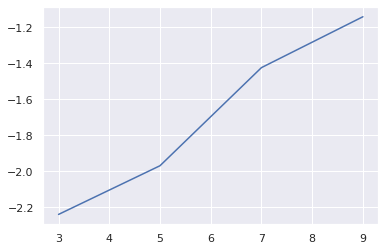

---Likelihoods---
Training: 5.703
Inlier: 5.629
Outlier: 2.235
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: -0.921336 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
-2.036758 (0.335865) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
-1.339708 (0.176498) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
-1.173057 (0.169268) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
-0.921336 (0.113587) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_com

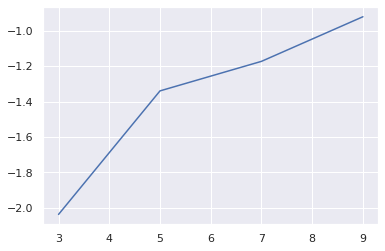

---Likelihoods---
Training: 6.707
Inlier: 6.826
Outlier: 6.237
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 1.927705 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
0.991715 (0.208024) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
1.104332 (0.260498) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
1.429184 (0.155606) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
1.927705 (0.138884) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_componen

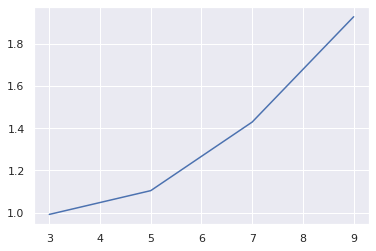

---Likelihoods---
Training: 11.336
Inlier: 11.150
Outlier: 6.515
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 6.712812 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
3.641443 (0.132532) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
5.182492 (0.288687) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
6.343708 (0.183032) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
6.712812 (0.131582) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_compon

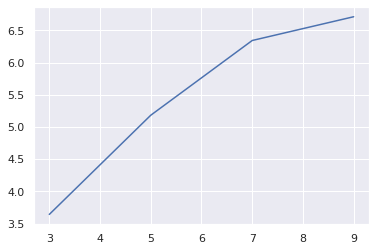

---Likelihoods---
Training: 17.827
Inlier: 17.564
Outlier: 18.722
========================= Training KD Tree =========================
========================= Training GMM =========================
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 4.178700 using {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 9}
---------------------------------------------------------------------------
-0.318253 (0.616696) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 3}
2.896346 (0.490134) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 5}
3.761962 (0.397344) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_components': 7}
4.178700 (0.346194) with: {'GMM__covariance_type': 'full', 'GMM__init_params': 'kmeans', 'GMM__max_iter': 1000, 'GMM__n_comp

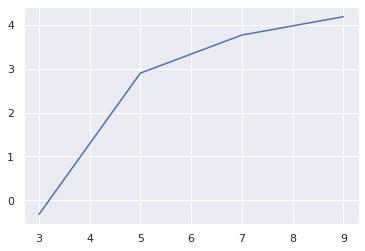

---Likelihoods---
Training: 14.919
Inlier: 14.987
Outlier: 14.306
========================= Training KD Tree =========================


In [9]:
all_metrics = []
for i in range(5):
    msma_results = get_msma_results(workdir, seed=i)
    all_metrics.append(msma_results)

In [10]:
gmm_metrics  = pd.concat(m["GMM"]["metrics"].reset_index(drop=True) for m in all_metrics
                        ).reset_index(drop=True)
gmm_metrics['seed'] = np.arange(5)
gmm_metrics['model'] = "MSMA-GMM"
gmm_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.855822,37.166310,57.344754,57.344754,1.666096,99.406168,61.048986,2.000000
std,1.077574,7.590041,18.960163,18.960163,0.870237,0.301473,12.565922,1.581139
min,0.801217,28.896027,39.721627,39.721627,0.760956,98.929386,42.814656,0.000000
25%,1.167542,30.339440,41.291934,41.291934,1.067667,99.364952,57.707458,1.000000
50%,1.798391,38.014513,56.388294,56.388294,1.681098,99.406821,58.897084,2.000000
75%,1.908962,41.722183,63.062099,63.062099,1.800579,99.646118,71.959183,3.000000
max,3.602998,46.859386,86.259814,86.259814,3.020181,99.683562,73.866550,4.000000


In [11]:
kd_metrics  = pd.concat(m["KD"]["metrics"].reset_index(drop=True) for m in all_metrics
                       ).reset_index(drop=True)
kd_metrics['seed'] = np.arange(5)
kd_metrics['model'] = "MSMA-KD"
kd_metrics

kd_metrics.describe()

,ap,de,fpr_tpr80,fpr_tpr95,pr_auc_in,pr_auc_out,roc_auc,seed
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1.825284,37.161551,60.192719,60.192719,1.579450,99.378573,59.123377,2.000000
std,1.496460,8.167882,17.189344,17.189344,1.105236,0.310564,14.006947,1.581139
min,0.740547,28.515346,40.863669,40.863669,0.705771,98.906889,39.256351,0.000000
25%,0.995792,29.306448,46.074233,46.074233,0.933098,99.257703,52.589420,1.000000
50%,1.130843,37.818225,60.171306,60.171306,1.072654,99.430824,59.182594,2.000000
75%,1.863125,43.593862,71.984297,71.984297,1.757926,99.646524,71.825680,3.000000
max,4.396115,46.573876,81.870093,81.870093,3.427802,99.650927,72.762841,4.000000


In [12]:
df_metrics = pd.concat([gmm_metrics, kd_metrics, baseline_metrics])
df_metrics[["roc_auc", "ap", "model"]].groupby('model').describe()

roc_auc                                                         \
           count       mean        std        min        25%        50%   
model                                                                     
DAGMM        5.0  45.586750  14.445277  25.656277  37.795754  48.219526   
DSVDD        5.0  59.135009  16.670859  29.658709  62.859862  65.492902   
ECOD         5.0  63.665107   0.650650  62.530732  63.709784  63.955640   
IForest      5.0  67.185608  13.221076  45.320803  65.952891  69.836360   
MSMA-GMM     5.0  61.048986  12.565922  42.814656  57.707458  58.897084   
MSMA-KD      5.0  59.123377  14.006947  39.256351  52.589420  59.182594   

                                  ap                                          \
                75%        max count      mean       std       min       25%   
model                                                                          
DAGMM     52.882861  63.379332   5.0  1.079678  0.440240  0.605219  0.824001   
DSVDD     68.349327  69.314246   5.0  1.471788  0.544284  0.642369  1.227353   
ECOD      64.044201  64.085177   5.0  1.432641  0.047393  1.355313  1.429450   
IForest   76.079256  78.738732   5.0  2.311274  1.360969  0.826589  1.513782   
MSMA-GMM  71.959183  73.866550   5.0  1.855822  1.077574  0.801217  1.167542   
MSMA-KD   71.825680  72.762841   5.0  1.825284  1.496460  0.740547  0.995792   

                                        
               50%       75%       max  
model                                   
DAGMM     1.078242  1.115948  1.774980  
DSVDD     1.677464  1.810676  2.001079  
ECOD      1.439281  1.459061  1.480102  
IForest   1.992955  2.874621  4.348424  
MSMA-GMM  1.798391  1.908962  3.602998  
MSMA-KD   1.130843  1.863125  4.396115

In [13]:
num_anos = len(all_metrics[0]["GMM"]["ood_scores"].ravel())
num_inliers = len(all_metrics[0]["GMM"]["test_scores"].ravel())
ano_ratio = num_anos / (num_anos+num_inliers)
print(f"Anomaly ratio for test set of {config.data.dataset}: {num_anos}/{num_inliers+num_anos} = {ano_ratio:.2f}")

Anomaly ratio for test set of chess: 27/2829 = 0.01


In [14]:
df_stats = df_metrics.groupby('model').describe()

for metric in ["ap", "roc_auc"]:
    latex_str = [metric]
    latex_str.append(f"{ano_ratio:.2f}")
    df = df_stats.loc[["IForest","ECOD","DAGMM","DSVDD","MSMA-GMM"], metric]
    best =  df["mean"].max()
    for m in df[["mean", "std"]].values:
        _str = f"{m[0]:.2f} \pm~{m[1]:.2f}" 
        if np.isclose(m[0], best):
            _str = "\B "+_str
        latex_str.append(_str)
    latex_str = " & ".join(latex_str)
    print(latex_str)

ap & 0.01 & \B 2.31 \pm~1.36 & 1.43 \pm~0.05 & 1.08 \pm~0.44 & 1.47 \pm~0.54 & 1.86 \pm~1.08
roc_auc & 0.01 & \B 67.19 \pm~13.22 & 63.67 \pm~0.65 & 45.59 \pm~14.45 & 59.14 \pm~16.67 & 61.05 \pm~12.57


In [15]:
df_melt = df_metrics.drop(columns="seed").melt(id_vars="model", var_name="metric")
df_melt

,model,metric,value
0,MSMA-GMM,ap,1.908962
1,MSMA-GMM,ap,1.167542
2,MSMA-GMM,ap,1.798391
3,MSMA-GMM,ap,0.801217
4,MSMA-GMM,ap,3.602998
...,...,...,...
205,DSVDD,roc_auc,62.859862
206,DSVDD,roc_auc,65.492902
207,DSVDD,roc_auc,68.349327
208,DSVDD,roc_auc,69.314246


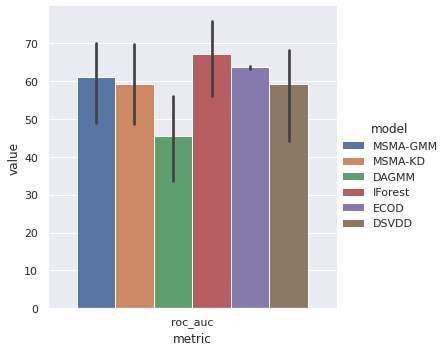

In [16]:
sns.catplot(data=df_melt.query("metric=='roc_auc'"), x="metric", y="value", hue="model", kind="bar")

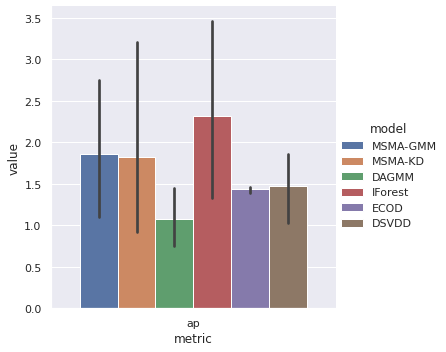

In [17]:
sns.catplot(data=df_melt.query("metric=='ap'"), x="metric", y="value", hue="model", kind="bar")